In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


''''
Goal is given a player and some of his stats from the last couple games and some stats on the opponent to output a prediction on the amount of points he will score in a game.
Glossary:

Rk -- Rank
Gcar -- Career Game Number for Player
Click to see career stats through the
end of this game for this player.
Gtm -- Season Game Number for Team
Click to see season stats through the
end of this game for this player.
GS -- Games Started
MP -- Minutes Played
FG -- Field Goals
FGA -- Field Goal Attempts
FG% -- Field Goal Percentage
3P -- 3-Point Field Goals
3PA -- 3-Point Field Goal Attempts
3P% -- 3-Point Field Goal Percentage
2P -- 2-Point Field Goals
2PA -- 2-Point Field Goal Attempts
2P% -- 2-Point Field Goal Percentage
eFG% -- Effective Field Goal Percentage
This statistic adjusts for the fact that a 3-point field goal is worth one more point than a 2-point field goal.
FT -- Free Throws
FTA -- Free Throw Attempts
FT% -- Free Throw Percentage
ORB -- Offensive Rebounds
DRB -- Defensive Rebounds
TRB -- Total Rebounds
AST -- Assists
STL -- Steals
BLK -- Blocks
TOV -- Turnovers
PF -- Personal Fouls
PTS -- Points
GmSc -- Game Score
+/- -- Plus-Minus


Feature set: (all computed before the game to avoid leakage)
1) Player recent form (rolling windows)

last5_pts_avg, last10_pts_avg

last5_min_avg, last5_fga_avg, last5_3pa_avg, last5_fta_avg

last1_min (workload last game)

Shooting efficiency proxies: last5_fg_pct, last5_ts_pct (if you have FTA/FGA/3PA)

Stability: last5_pts_std (variance in role/performance)

2) Workload & rest

days_rest (since previous game)

is_b2b (back-to-back), games_past_7d

3) Opponent team defense & pace (season-to-date or last-N games)

opp_def_rating (points allowed per 100 possessions). 
NBA
+1

Opponent Four Factors (defense): opp_def_efg, opp_def_tov_pct, opp_def_drb_pct, opp_def_ft_fga. 
NBA
+1

opp_pace (possessions per 48). 
Basketball Reference

4) Context

home (1=home, 0=away)

month_sin, month_cos (seasonality)

team_pace_sd (your team’s pace season-to-date)



'''

## Data wrangling, feature engineering

In [50]:
numeric_cols = ["Rk","Gcar","Gtm","FG","FGA","FG%","3P","3PA","3P%","2P","2PA","2P%","eFG%","FT","FTA","FT%","ORB","DRB","TRB","AST","STL","BLK","TOV","PF","PTS","GmSc","+/-"]
giannis_2025_df = pd.read_csv("data/giannis_2025.csv", converters={c: (lambda x: pd.to_numeric(x, errors="ignore")) for c in numeric_cols})

giannis_2025_df.head()
giannis_2025_df.dtypes

C:\Users\Jon\AppData\Local\Temp\ipykernel_18052\2451024663.py:2: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  giannis_2025_df = pd.read_csv("data/giannis_2025.csv", converters={c: (lambda x: pd.to_numeric(x, errors="ignore")) for c in numeric_cols})


Rk            float64
Gcar          float64
Gtm           float64
Date           object
Team           object
Unnamed: 5     object
Opp            object
Result         object
GS             object
MP             object
FG             object
FGA            object
FG%            object
3P             object
3PA            object
3P%            object
2P             object
2PA            object
2P%            object
eFG%           object
FT             object
FTA            object
FT%            object
ORB            object
DRB            object
TRB            object
AST            object
STL            object
BLK            object
TOV            object
PF             object
PTS            object
GmSc           object
+/-            object
dtype: object

In [53]:
giannis_2025_df.rename(columns={"Unnamed: 5": "Home Game"}, inplace=True)
giannis_2025_df.head()

,Rk,Gcar,Gtm,Date,Team,Home Game,Opp,Result,GS,MP,...,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,GmSc,+/-
0,1.0,793.0,1.0,2024-10-23,MIL,@,PHI,W 124-109,*,31:12,...,13,14,7,0,1,3,4,25,23.3,7
1,2.0,794.0,2.0,2024-10-25,MIL,NaN,CHI,L 122-133,*,35:08,...,10,11,5,0,0,3,1,38,28.5,-12
2,3.0,795.0,3.0,2024-10-27,MIL,@,BRK,L 102-115,*,33:19,...,11,12,7,1,1,4,3,22,21.3,-11
3,4.0,796.0,4.0,2024-10-28,MIL,@,BOS,L 108-119,*,39:05,...,9,10,6,0,0,7,4,30,14.8,-19
4,5.0,797.0,5.0,2024-10-31,MIL,@,MEM,L 99-122,*,33:31,...,10,11,4,1,1,1,4,37,32.0,0


In [54]:
giannis_2025_df["Home Game"] = giannis_2025_df["Home Game"] != "@"
giannis_2025_df.head()

,Rk,Gcar,Gtm,Date,Team,Home Game,Opp,Result,GS,MP,...,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,GmSc,+/-
0,1.0,793.0,1.0,2024-10-23,MIL,False,PHI,W 124-109,*,31:12,...,13,14,7,0,1,3,4,25,23.3,7
1,2.0,794.0,2.0,2024-10-25,MIL,True,CHI,L 122-133,*,35:08,...,10,11,5,0,0,3,1,38,28.5,-12
2,3.0,795.0,3.0,2024-10-27,MIL,False,BRK,L 102-115,*,33:19,...,11,12,7,1,1,4,3,22,21.3,-11
3,4.0,796.0,4.0,2024-10-28,MIL,False,BOS,L 108-119,*,39:05,...,9,10,6,0,0,7,4,30,14.8,-19
4,5.0,797.0,5.0,2024-10-31,MIL,False,MEM,L 99-122,*,33:31,...,10,11,4,1,1,1,4,37,32.0,0


In [84]:
def mmss_to_minutes(x):
    if pd.isna(x):
        return np.nan
    try:
        m, s = str(x).split(":")
        return int(m) + int(s) / 60.0
    except Exception:
        return np.nan

giannis_2025_df["MP_min"] = giannis_2025_df["MP"].apply(mmss_to_minutes)
giannis_2025_df.head()

,Rk,Gcar,Gtm,Date,Team,Home Game,Opp,Result,GS,MP,...,TRB,AST,STL,BLK,TOV,PF,PTS,GmSc,+/-,MP_min
0,1.0,793.0,1.0,2024-10-23,MIL,False,PHI,W 124-109,*,31:12,...,14,7,0,1,3,4,25,23.3,7,31.200000
1,2.0,794.0,2.0,2024-10-25,MIL,True,CHI,L 122-133,*,35:08,...,11,5,0,0,3,1,38,28.5,-12,35.133333
2,3.0,795.0,3.0,2024-10-27,MIL,False,BRK,L 102-115,*,33:19,...,12,7,1,1,4,3,22,21.3,-11,33.316667
3,4.0,796.0,4.0,2024-10-28,MIL,False,BOS,L 108-119,*,39:05,...,10,6,0,0,7,4,30,14.8,-19,39.083333
4,5.0,797.0,5.0,2024-10-31,MIL,False,MEM,L 99-122,*,33:31,...,11,4,1,1,1,4,37,32.0,0,33.516667


In [112]:
giannis_2025_df["Date"] = pd.to_datetime(giannis_2025_df["Date"], errors="coerce")

In [111]:
def get_rolling_average(cat, amount_num, df):
        rolling_average = pd.Series()
        for i in range(amount_num, len(df)):
            rolling_average[i] = pd.to_numeric(df[cat][(i - amount_num):i], errors="coerce").mean()
        return rolling_average

In [180]:
get_rolling_average("PTS", amount_num=10, df=giannis_2025_df).tail(20)

63    27.300000
64    26.900000
65    27.500000
66    28.600000
67    28.000000
68    27.200000
69    27.100000
70    27.700000
71    27.600000
72    26.555556
73    26.555556
74    27.888889
75    29.333333
76    29.444444
77    31.111111
78    32.500000
79    31.875000
80    31.375000
81    31.500000
82    31.500000
dtype: float64

In [101]:
giannis_2025_df["MP_min"][5:]

5     38.866667
6           NaN
7     30.200000
8     32.200000
9     39.150000
        ...    
78    37.650000
79    25.566667
80    37.766667
81          NaN
82          NaN
Name: MP_min, Length: 78, dtype: float64

In [102]:
giannis_2025_df["MP_min"][5:].shift(1)

5           NaN
6     38.866667
7           NaN
8     30.200000
9     32.200000
        ...    
78          NaN
79    37.650000
80    25.566667
81    37.766667
82          NaN
Name: MP_min, Length: 78, dtype: float64

In [109]:
giannis_2025_df.iloc[3]

Rk                  4.0
Gcar              796.0
Gtm                 4.0
Date         2024-10-28
Team                MIL
Home Game         False
Opp                 BOS
Result        L 108-119
GS                    *
MP                39:05
FG                   14
FGA                  26
FG%               0.538
3P                    0
3PA                   2
3P%                 0.0
2P                   14
2PA                  24
2P%               0.583
eFG%              0.538
FT                    2
FTA                   6
FT%               0.333
ORB                   1
DRB                   9
TRB                  10
AST                   6
STL                   0
BLK                   0
TOV                   7
PF                    4
PTS                  30
GmSc               14.8
+/-                 -19
MP_min        39.083333
Name: 3, dtype: object

In [120]:
(giannis_2025_df["Date"] - giannis_2025_df["Date"].shift(1)).dt.days

0     NaN
1     2.0
2     2.0
3     1.0
4     3.0
     ... 
78    2.0
79    2.0
80    1.0
81    2.0
82    NaN
Name: Date, Length: 83, dtype: float64

In [119]:
giannis_2025_df["Date"]

0    2024-10-23
1    2024-10-25
2    2024-10-27
3    2024-10-28
4    2024-10-31
        ...    
78   2025-04-08
79   2025-04-10
80   2025-04-11
81   2025-04-13
82          NaT
Name: Date, Length: 83, dtype: datetime64[ns]

In [121]:
# Recent game data

giannis_feature_set_df["last5_pts_avg"] = get_rolling_average(cat="PTS", amount_num=5, df=giannis_2025_df)
giannis_feature_set_df["last5_min_avg"] = get_rolling_average(cat="MP_min", amount_num=5, df=giannis_2025_df)
giannis_feature_set_df["last5_fga_avg"] = get_rolling_average(cat="FGA", amount_num=5, df=giannis_2025_df)
giannis_feature_set_df["last5_3pa_avg"] = get_rolling_average(cat="3PA", amount_num=5, df=giannis_2025_df)
giannis_feature_set_df["last5_fta_avg"] = get_rolling_average(cat="FTA", amount_num=5, df=giannis_2025_df)
giannis_feature_set_df["last1_min_played"] = giannis_2025_df["MP_min"].shift(1)
giannis_feature_set_df["last5_efg_avg"] = get_rolling_average(cat="eFG%", amount_num=5, df=giannis_2025_df)
giannis_feature_set_df["days_rest"] = (giannis_2025_df["Date"] - giannis_2025_df["Date"].shift(1)).dt.days
giannis_feature_set_df.head(10)

,last5_pts_avg,last5_min_avg,last5_fga_avg,last5_3pa_avg,last5_fta_avg,last1_min_played,last5_efg_avg,days_rest
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,31.200000,NaN,2.0
2,NaN,NaN,NaN,NaN,NaN,35.133333,NaN,2.0
3,NaN,NaN,NaN,NaN,NaN,33.316667,NaN,1.0
4,NaN,NaN,NaN,NaN,NaN,39.083333,NaN,3.0
5,30.40,34.450000,18.60,0.60,11.40,33.516667,0.66520,2.0
6,32.20,35.983333,21.80,0.60,9.60,38.866667,0.63100,2.0
7,30.75,36.195833,21.50,0.50,8.00,NaN,0.62575,3.0
8,33.00,35.416667,24.00,0.50,8.25,30.200000,0.59775,1.0
9,31.50,33.695833,22.75,0.25,8.25,32.200000,0.59425,2.0


In [125]:
team_defense_stats_25 = pd.read_csv("data/team-stats-2025.csv")
team_defense_stats_25.tail()

,Rk,Team,DRtg,Pace,eFG%,TOV%,DRB%,FT/FGA
26,27.0,Utah Jazz,120.4,100.0,0.559,10.3,74.1,0.185
27,28.0,Charlotte Hornets,116.6,97.6,0.547,11.9,74.5,0.190
28,29.0,New Orleans Pelicans,119.9,99.1,0.564,12.3,72.7,0.190
29,30.0,Washington Wizards,119.1,100.9,0.548,11.4,71.9,0.202
30,NaN,League Average,114.5,98.8,0.543,12.6,74.8,0.189


In [128]:
team_defense_stats_25.drop(30, inplace=True)

In [129]:
team_defense_stats_25.tail()

,Rk,Team,DRtg,Pace,eFG%,TOV%,DRB%,FT/FGA
25,26.0,Brooklyn Nets,115.8,96.4,0.557,13.7,75.0,0.218
26,27.0,Utah Jazz,120.4,100.0,0.559,10.3,74.1,0.185
27,28.0,Charlotte Hornets,116.6,97.6,0.547,11.9,74.5,0.190
28,29.0,New Orleans Pelicans,119.9,99.1,0.564,12.3,72.7,0.190
29,30.0,Washington Wizards,119.1,100.9,0.548,11.4,71.9,0.202


In [130]:
NAME_TO_ABBR = {
    "Atlanta Hawks": "ATL",
    "Boston Celtics": "BOS",
    "Brooklyn Nets": "BRK",   # B-Ref uses BRK (not BKN)
    "Charlotte Hornets": "CHO",# B-Ref uses CHO (not CHA)
    "Chicago Bulls": "CHI",
    "Cleveland Cavaliers": "CLE",
    "Dallas Mavericks": "DAL",
    "Denver Nuggets": "DEN",
    "Detroit Pistons": "DET",
    "Golden State Warriors": "GSW",
    "Houston Rockets": "HOU",
    "Indiana Pacers": "IND",
    "Los Angeles Clippers": "LAC",
    "Los Angeles Lakers": "LAL",
    "Memphis Grizzlies": "MEM",
    "Miami Heat": "MIA",
    "Milwaukee Bucks": "MIL",
    "Minnesota Timberwolves": "MIN",
    "New Orleans Pelicans": "NOP",
    "New York Knicks": "NYK",
    "Oklahoma City Thunder": "OKC",
    "Orlando Magic": "ORL",
    "Philadelphia 76ers": "PHI",
    "Phoenix Suns": "PHO",    # B-Ref uses PHO (not PHX)
    "Portland Trail Blazers": "POR",
    "Sacramento Kings": "SAC",
    "San Antonio Spurs": "SAS",
    "Toronto Raptors": "TOR",
    "Utah Jazz": "UTA",
    "Washington Wizards": "WAS",
    # (optional) handle Sacramento already included above
}

In [132]:
team_defense_stats_25["Team"] = team_defense_stats_25["Team"].str.replace("*", "", regex=False).str.strip()
team_defense_stats_25["Team_abbr"] = team_defense_stats_25["Team"].map(NAME_TO_ABBR)
team_defense_stats_25.head(30)

,Rk,Team,DRtg,Pace,eFG%,TOV%,DRB%,FT/FGA,Team_abbr
0,1.0,Oklahoma City Thunder,107.5,100.0,0.513,14.9,74.6,0.211,OKC
1,2.0,Boston Celtics,111.1,95.7,0.522,11.6,76.0,0.154,BOS
2,3.0,Cleveland Cavaliers,112.2,99.8,0.528,12.6,74.8,0.181,CLE
3,4.0,Minnesota Timberwolves,111.5,97.3,0.532,13.2,75.1,0.178,MIN
4,5.0,Los Angeles Clippers,110.3,97.5,0.536,13.7,77.5,0.189,LAC
5,6.0,Memphis Grizzlies,113.0,103.3,0.533,12.9,74.9,0.206,MEM
6,7.0,Houston Rockets,110.8,98.6,0.528,12.8,76.2,0.186,HOU
7,8.0,New York Knicks,114.3,96.7,0.549,13.1,74.5,0.176,NYK
8,9.0,Denver Nuggets,116.0,99.8,0.542,11.3,74.6,0.173,DEN
9,10.0,Golden State Warriors,111.7,98.7,0.541,14.1,75.6,0.189,GSW


In [133]:
team_defense_stats_25.set_index("Team_abbr", inplace=True)
team_defense_stats_25.head(30)

,Rk,Team,DRtg,Pace,eFG%,TOV%,DRB%,FT/FGA
Team_abbr,,,,,,,,
OKC,1.0,Oklahoma City Thunder,107.5,100.0,0.513,14.9,74.6,0.211
BOS,2.0,Boston Celtics,111.1,95.7,0.522,11.6,76.0,0.154
CLE,3.0,Cleveland Cavaliers,112.2,99.8,0.528,12.6,74.8,0.181
MIN,4.0,Minnesota Timberwolves,111.5,97.3,0.532,13.2,75.1,0.178
LAC,5.0,Los Angeles Clippers,110.3,97.5,0.536,13.7,77.5,0.189
MEM,6.0,Memphis Grizzlies,113.0,103.3,0.533,12.9,74.9,0.206
HOU,7.0,Houston Rockets,110.8,98.6,0.528,12.8,76.2,0.186
NYK,8.0,New York Knicks,114.3,96.7,0.549,13.1,74.5,0.176
DEN,9.0,Denver Nuggets,116.0,99.8,0.542,11.3,74.6,0.173


In [135]:
team_defense_stats_25.loc["NYK"]

Rk                    8.0
Team      New York Knicks
DRtg                114.3
Pace                 96.7
eFG%                0.549
TOV%                 13.1
DRB%                 74.5
FT/FGA              0.176
Name: NYK, dtype: object

In [136]:
# Use team defense stats to set team defense features in feature df
giannis_2025_df.head()

,Rk,Gcar,Gtm,Date,Team,Home Game,Opp,Result,GS,MP,...,TRB,AST,STL,BLK,TOV,PF,PTS,GmSc,+/-,MP_min
0,1.0,793.0,1.0,2024-10-23,MIL,False,PHI,W 124-109,*,31:12,...,14,7,0,1,3,4,25,23.3,7,31.200000
1,2.0,794.0,2.0,2024-10-25,MIL,True,CHI,L 122-133,*,35:08,...,11,5,0,0,3,1,38,28.5,-12,35.133333
2,3.0,795.0,3.0,2024-10-27,MIL,False,BRK,L 102-115,*,33:19,...,12,7,1,1,4,3,22,21.3,-11,33.316667
3,4.0,796.0,4.0,2024-10-28,MIL,False,BOS,L 108-119,*,39:05,...,10,6,0,0,7,4,30,14.8,-19,39.083333
4,5.0,797.0,5.0,2024-10-31,MIL,False,MEM,L 99-122,*,33:31,...,11,4,1,1,1,4,37,32.0,0,33.516667


In [ ]:
cols = ["DRtg","Pace","eFG%","TOV%","DRB%","FT/FGA"]  # pick what you need
giannis_2025_df = giannis_2025_df.join(
    team_defense_stats_25[cols].add_prefix("opp_"),  # avoid name collisions
    on="Opp"                          # join key is giannis_df['Opp'] vs def_df.index
)

In [141]:
giannis_2025_df.head()

,Rk,Gcar,Gtm,Date,Team,Home Game,Opp,Result,GS,MP,...,PTS,GmSc,+/-,MP_min,opp_DRtg,opp_Pace,opp_eFG%,opp_TOV%,opp_DRB%,opp_FT/FGA
0,1.0,793.0,1.0,2024-10-23,MIL,False,PHI,W 124-109,*,31:12,...,25,23.3,7,31.200000,118.2,97.4,0.570,14.3,71.8,0.194
1,2.0,794.0,2.0,2024-10-25,MIL,True,CHI,L 122-133,*,35:08,...,38,28.5,-12,35.133333,115.6,102.8,0.539,10.8,76.6,0.178
2,3.0,795.0,3.0,2024-10-27,MIL,False,BRK,L 102-115,*,33:19,...,22,21.3,-11,33.316667,115.8,96.4,0.557,13.7,75.0,0.218
3,4.0,796.0,4.0,2024-10-28,MIL,False,BOS,L 108-119,*,39:05,...,30,14.8,-19,39.083333,111.1,95.7,0.522,11.6,76.0,0.154
4,5.0,797.0,5.0,2024-10-31,MIL,False,MEM,L 99-122,*,33:31,...,37,32.0,0,33.516667,113.0,103.3,0.533,12.9,74.9,0.206


In [143]:
opp_cols = []
for col in cols:
    opp_cols.append("opp_" + col)
opp_cols

['opp_DRtg', 'opp_Pace', 'opp_eFG%', 'opp_TOV%', 'opp_DRB%', 'opp_FT/FGA']

In [146]:
giannis_feature_set_df = giannis_feature_set_df.join(
    giannis_2025_df[opp_cols]
)
giannis_feature_set_df

,last5_pts_avg,last5_min_avg,last5_fga_avg,last5_3pa_avg,last5_fta_avg,last1_min_played,last5_efg_avg,days_rest,opp_DRtg,opp_Pace,opp_eFG%,opp_TOV%,opp_DRB%,opp_FT/FGA
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,118.2,97.4,0.570,14.3,71.8,0.194
1,NaN,NaN,NaN,NaN,NaN,31.200000,NaN,2.0,115.6,102.8,0.539,10.8,76.6,0.178
2,NaN,NaN,NaN,NaN,NaN,35.133333,NaN,2.0,115.8,96.4,0.557,13.7,75.0,0.218
3,NaN,NaN,NaN,NaN,NaN,33.316667,NaN,1.0,111.1,95.7,0.522,11.6,76.0,0.154
4,NaN,NaN,NaN,NaN,NaN,39.083333,NaN,3.0,113.0,103.3,0.533,12.9,74.9,0.206
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,30.25,33.900000,17.75,1.25,12.25,34.866667,0.62625,2.0,115.7,102.6,0.560,13.8,76.0,0.202
74,31.00,34.245833,18.50,1.50,12.75,30.433333,0.62900,2.0,119.3,97.1,0.552,10.9,74.1,0.191
75,32.25,34.666667,18.00,2.50,12.50,36.266667,0.65950,2.0,118.2,97.4,0.570,14.3,71.8,0.194
76,33.25,35.075000,18.00,2.25,12.00,38.733333,0.65950,2.0,112.9,96.2,0.543,12.5,75.8,0.157


In [148]:
giannis_feature_set_df = giannis_feature_set_df.join(
    giannis_2025_df["Home Game"].astype(int)
)

In [149]:
giannis_feature_set_df

,last5_pts_avg,last5_min_avg,last5_fga_avg,last5_3pa_avg,last5_fta_avg,last1_min_played,last5_efg_avg,days_rest,opp_DRtg,opp_Pace,opp_eFG%,opp_TOV%,opp_DRB%,opp_FT/FGA,Home Game
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,118.2,97.4,0.570,14.3,71.8,0.194,0
1,NaN,NaN,NaN,NaN,NaN,31.200000,NaN,2.0,115.6,102.8,0.539,10.8,76.6,0.178,1
2,NaN,NaN,NaN,NaN,NaN,35.133333,NaN,2.0,115.8,96.4,0.557,13.7,75.0,0.218,0
3,NaN,NaN,NaN,NaN,NaN,33.316667,NaN,1.0,111.1,95.7,0.522,11.6,76.0,0.154,0
4,NaN,NaN,NaN,NaN,NaN,39.083333,NaN,3.0,113.0,103.3,0.533,12.9,74.9,0.206,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,30.25,33.900000,17.75,1.25,12.25,34.866667,0.62625,2.0,115.7,102.6,0.560,13.8,76.0,0.202,1
74,31.00,34.245833,18.50,1.50,12.75,30.433333,0.62900,2.0,119.3,97.1,0.552,10.9,74.1,0.191,1
75,32.25,34.666667,18.00,2.50,12.50,36.266667,0.65950,2.0,118.2,97.4,0.570,14.3,71.8,0.194,0
76,33.25,35.075000,18.00,2.25,12.00,38.733333,0.65950,2.0,112.9,96.2,0.543,12.5,75.8,0.157,0


In [151]:
# Drop first 5 games since we can't get rolling averages
giannis_feature_set_df = giannis_feature_set_df.loc[5:]
giannis_feature_set_df.head()

,last5_pts_avg,last5_min_avg,last5_fga_avg,last5_3pa_avg,last5_fta_avg,last1_min_played,last5_efg_avg,days_rest,opp_DRtg,opp_Pace,opp_eFG%,opp_TOV%,opp_DRB%,opp_FT/FGA,Home Game
5,30.40,34.450000,18.60,0.60,11.40,33.516667,0.66520,2.0,112.2,99.8,0.528,12.6,74.8,0.181,1
6,32.20,35.983333,21.80,0.60,9.60,38.866667,0.63100,2.0,112.2,99.8,0.528,12.6,74.8,0.181,0
7,30.75,36.195833,21.50,0.50,8.00,NaN,0.62575,3.0,120.4,100.0,0.559,10.3,74.1,0.185,1
8,33.00,35.416667,24.00,0.50,8.25,30.200000,0.59775,1.0,114.3,96.7,0.549,13.1,74.5,0.176,0
9,31.50,33.695833,22.75,0.25,8.25,32.200000,0.59425,2.0,111.1,95.7,0.522,11.6,76.0,0.154,1


In [171]:
giannis_2025_df.head(42)

,Rk,Gcar,Gtm,Date,Team,Home Game,Opp,Result,GS,MP,...,PTS,GmSc,+/-,MP_min,opp_DRtg,opp_Pace,opp_eFG%,opp_TOV%,opp_DRB%,opp_FT/FGA
0,1.0,793.0,1.0,2024-10-23,MIL,False,PHI,W 124-109,*,31:12,...,25,23.3,7,31.200000,118.2,97.4,0.570,14.3,71.8,0.194
1,2.0,794.0,2.0,2024-10-25,MIL,True,CHI,L 122-133,*,35:08,...,38,28.5,-12,35.133333,115.6,102.8,0.539,10.8,76.6,0.178
2,3.0,795.0,3.0,2024-10-27,MIL,False,BRK,L 102-115,*,33:19,...,22,21.3,-11,33.316667,115.8,96.4,0.557,13.7,75.0,0.218
3,4.0,796.0,4.0,2024-10-28,MIL,False,BOS,L 108-119,*,39:05,...,30,14.8,-19,39.083333,111.1,95.7,0.522,11.6,76.0,0.154
4,5.0,797.0,5.0,2024-10-31,MIL,False,MEM,L 99-122,*,33:31,...,37,32.0,0,33.516667,113.0,103.3,0.533,12.9,74.9,0.206
5,6.0,798.0,6.0,2024-11-02,MIL,True,CLE,L 113-114,*,38:52,...,34,32.4,5,38.866667,112.2,99.8,0.528,12.6,74.8,0.181
6,6.0,NaN,7.0,2024-11-04,MIL,False,CLE,L 114-116,Inactive,Inactive,...,Inactive,Inactive,Inactive,NaN,112.2,99.8,0.528,12.6,74.8,0.181
7,7.0,799.0,8.0,2024-11-07,MIL,True,UTA,W 123-100,*,30:12,...,31,23.8,27,30.200000,120.4,100.0,0.559,10.3,74.1,0.185
8,8.0,800.0,9.0,2024-11-08,MIL,False,NYK,L 94-116,*,32:12,...,24,17.9,-17,32.200000,114.3,96.7,0.549,13.1,74.5,0.176
9,9.0,801.0,10.0,2024-11-10,MIL,True,BOS,L 107-113,*,39:09,...,43,34.9,-6,39.150000,111.1,95.7,0.522,11.6,76.0,0.154


In [153]:
giannis_feature_set_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 73 entries, 5 to 77
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   last5_pts_avg     71 non-null     float64
 1   last5_min_avg     71 non-null     float64
 2   last5_fga_avg     71 non-null     float64
 3   last5_3pa_avg     71 non-null     float64
 4   last5_fta_avg     71 non-null     float64
 5   last1_min_played  60 non-null     float64
 6   last5_efg_avg     71 non-null     float64
 7   days_rest         73 non-null     float64
 8   opp_DRtg          73 non-null     float64
 9   opp_Pace          73 non-null     float64
 10  opp_eFG%          73 non-null     float64
 11  opp_TOV%          73 non-null     float64
 12  opp_DRB%          73 non-null     float64
 13  opp_FT/FGA        73 non-null     float64
 14  Home Game         73 non-null     int64  
dtypes: float64(14), int64(1)
memory usage: 9.1 KB


In [176]:
giannis_feature_set_df.head(41)

,last5_pts_avg,last5_min_avg,last5_fga_avg,last5_3pa_avg,last5_fta_avg,last1_min_played,last5_efg_avg,days_rest,opp_DRtg,opp_Pace,opp_eFG%,opp_TOV%,opp_DRB%,opp_FT/FGA,Home Game
5,30.400000,34.450000,18.600000,0.600000,11.400000,33.516667,0.665200,2.0,112.2,99.8,0.528,12.6,74.8,0.181,1
6,32.200000,35.983333,21.800000,0.600000,9.600000,38.866667,0.631000,2.0,112.2,99.8,0.528,12.6,74.8,0.181,0
7,30.750000,36.195833,21.500000,0.500000,8.000000,NaN,0.625750,3.0,120.4,100.0,0.559,10.3,74.1,0.185,1
8,33.000000,35.416667,24.000000,0.500000,8.250000,30.200000,0.597750,1.0,114.3,96.7,0.549,13.1,74.5,0.176,0
9,31.500000,33.695833,22.750000,0.250000,8.250000,32.200000,0.594250,2.0,111.1,95.7,0.522,11.6,76.0,0.154,1
10,33.000000,35.104167,24.500000,0.750000,8.750000,39.150000,0.560500,2.0,114.8,99.7,0.541,13.2,73.9,0.222,1
11,30.250000,33.720833,20.750000,1.000000,9.250000,33.333333,0.609000,1.0,113.1,99.8,0.539,13.3,76.0,0.214,1
12,36.000000,35.703333,23.400000,1.200000,10.800000,43.633333,0.613600,3.0,116.6,97.6,0.547,11.9,74.5,0.190,0
13,34.200000,36.360000,23.600000,1.400000,8.600000,33.483333,0.608800,2.0,110.8,98.6,0.528,12.8,76.2,0.186,1
14,33.400000,37.036667,22.800000,1.200000,8.800000,35.583333,0.609800,2.0,115.6,102.8,0.539,10.8,76.6,0.178,1


In [177]:
giannis_feature_set_df.tail(32)

,last5_pts_avg,last5_min_avg,last5_fga_avg,last5_3pa_avg,last5_fta_avg,last1_min_played,last5_efg_avg,days_rest,opp_DRtg,opp_Pace,opp_eFG%,opp_TOV%,opp_DRB%,opp_FT/FGA,Home Game
46,34.000000,34.693333,22.000000,0.600000,11.800000,34.000000,0.614000,2.0,113.0,103.3,0.533,12.9,74.9,0.206,1
47,35.000000,35.743333,22.600000,1.200000,11.000000,37.183333,0.645600,1.0,107.5,100.0,0.513,14.9,74.6,0.211,0
48,34.750000,35.929167,22.750000,1.250000,10.000000,NaN,0.670750,2.0,116.6,97.6,0.547,11.9,74.5,0.190,0
49,34.666667,35.700000,22.666667,1.333333,10.000000,NaN,0.662333,2.0,115.7,102.6,0.560,13.8,76.0,0.202,0
50,32.500000,35.591667,22.000000,2.000000,10.000000,NaN,0.639500,2.0,118.2,97.4,0.570,14.3,71.8,0.194,1
51,30.000000,37.183333,21.000000,3.000000,6.000000,NaN,0.714000,1.0,111.7,98.7,0.541,14.1,75.6,0.189,1
52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,111.5,97.3,0.532,13.2,75.1,0.178,0
53,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,110.3,97.5,0.536,13.7,77.5,0.189,1
54,23.000000,23.750000,14.000000,2.000000,5.000000,23.750000,0.714000,1.0,119.1,100.9,0.548,11.4,71.9,0.202,0
55,20.500000,21.525000,11.500000,1.000000,8.000000,19.300000,0.690500,2.0,112.9,96.2,0.543,12.5,75.8,0.157,1


In [174]:
len(giannis_2025_df)

83

In [175]:
len(giannis_feature_set_df)

73

In [181]:
giannis_2025_df.tail(10)

,Rk,Gcar,Gtm,Date,Team,Home Game,Opp,Result,GS,MP,...,PTS,GmSc,+/-,MP_min,opp_DRtg,opp_Pace,opp_eFG%,opp_TOV%,opp_DRB%,opp_FT/FGA
73,61.0,853.0,74.0,2025-03-30,MIL,True,ATL,L 124-145,*,30:26,...,31,22.2,-18,30.433333,115.7,102.6,0.560,13.8,76.0,0.202
74,62.0,854.0,75.0,2025-04-01,MIL,True,PHO,W 133-123,*,36:16,...,37,39.3,23,36.266667,119.3,97.1,0.552,10.9,74.1,0.191
75,63.0,855.0,76.0,2025-04-03,MIL,False,PHI,W 126-113,*,38:44,...,35,46.0,23,38.733333,118.2,97.4,0.570,14.3,71.8,0.194
76,64.0,856.0,77.0,2025-04-05,MIL,False,MIA,W 121-115 (OT),*,43:00,...,36,33.7,17,43.000000,112.9,96.2,0.543,12.5,75.8,0.157
77,64.0,NaN,78.0,2025-04-06,MIL,False,NOP,W 111-107,Inactive,Inactive,...,Inactive,Inactive,Inactive,NaN,119.9,99.1,0.564,12.3,72.7,0.190
78,65.0,857.0,79.0,2025-04-08,MIL,True,MIN,W 110-103,*,37:39,...,23,27.1,26,37.650000,111.5,97.3,0.532,13.2,75.1,0.178
79,66.0,858.0,80.0,2025-04-10,MIL,True,NOP,W 136-111,*,25:34,...,28,26.4,6,25.566667,119.9,99.1,0.564,12.3,72.7,0.190
80,67.0,859.0,81.0,2025-04-11,MIL,False,DET,W 125-119,*,37:46,...,32,34.2,22,37.766667,113.1,99.8,0.539,13.3,76.0,0.214
81,67.0,NaN,82.0,2025-04-13,MIL,True,DET,W 140-133 (OT),Inactive,Inactive,...,Inactive,Inactive,Inactive,NaN,113.1,99.8,0.539,13.3,76.0,0.214
82,NaN,NaN,NaN,NaT,NaN,True,NaN,40-27,67,2291,...,2036,26.4,334,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [182]:
giannis_feature_set_df.to_csv("giannis_features.csv")

In [185]:
giannis_feature_set_df[giannis_feature_set_df["last1_min_played"].isna()]

,last5_pts_avg,last5_min_avg,last5_fga_avg,last5_3pa_avg,last5_fta_avg,last1_min_played,last5_efg_avg,days_rest,opp_DRtg,opp_Pace,opp_eFG%,opp_TOV%,opp_DRB%,opp_FT/FGA,Home Game
7,30.750000,36.195833,21.500000,0.500000,8.000000,NaN,0.625750,3.0,120.4,100.0,0.559,10.3,74.1,0.185,1
18,32.500000,34.295833,21.250000,1.000000,10.500000,NaN,0.611750,4.0,119.1,100.9,0.548,11.4,71.9,0.202,1
27,34.000000,35.483333,20.750000,0.750000,12.500000,NaN,0.635500,2.0,115.6,102.8,0.539,10.8,76.6,0.178,0
28,34.000000,34.638889,20.333333,1.000000,13.333333,NaN,0.635333,3.0,115.8,96.4,0.557,13.7,75.0,0.218,1
29,32.500000,34.158333,18.500000,0.500000,14.000000,NaN,0.640500,2.0,115.6,102.8,0.539,10.8,76.6,0.178,0
30,33.000000,30.416667,22.000000,1.000000,10.000000,NaN,0.614000,3.0,114.3,99.9,0.546,13.1,74.5,0.190,0
48,34.750000,35.929167,22.750000,1.250000,10.000000,NaN,0.670750,2.0,116.6,97.6,0.547,11.9,74.5,0.190,0
49,34.666667,35.700000,22.666667,1.333333,10.000000,NaN,0.662333,2.0,115.7,102.6,0.560,13.8,76.0,0.202,0
50,32.500000,35.591667,22.000000,2.000000,10.000000,NaN,0.639500,2.0,118.2,97.4,0.570,14.3,71.8,0.194,1
51,30.000000,37.183333,21.000000,3.000000,6.000000,NaN,0.714000,1.0,111.7,98.7,0.541,14.1,75.6,0.189,1


In [187]:
giannis_feature_set_df["last1_min_played"] = giannis_feature_set_df["last1_min_played"].fillna(0)

C:\Users\Jon\AppData\Local\Temp\ipykernel_18052\2002071184.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  giannis_feature_set_df["last1_min_played"] = giannis_feature_set_df["last1_min_played"].fillna(0)


In [196]:
len(giannis_feature_set_df)

73

In [197]:
giannis_pts_y_set = giannis_2025_df["PTS"][5:78]

In [201]:
giannis_feature_set_df.dropna()

,last5_pts_avg,last5_min_avg,last5_fga_avg,last5_3pa_avg,last5_fta_avg,last1_min_played,last5_efg_avg,days_rest,opp_DRtg,opp_Pace,opp_eFG%,opp_TOV%,opp_DRB%,opp_FT/FGA,Home Game
5,30.40,34.450000,18.60,0.60,11.40,33.516667,0.66520,2.0,112.2,99.8,0.528,12.6,74.8,0.181,1
6,32.20,35.983333,21.80,0.60,9.60,38.866667,0.63100,2.0,112.2,99.8,0.528,12.6,74.8,0.181,0
7,30.75,36.195833,21.50,0.50,8.00,0.000000,0.62575,3.0,120.4,100.0,0.559,10.3,74.1,0.185,1
8,33.00,35.416667,24.00,0.50,8.25,30.200000,0.59775,1.0,114.3,96.7,0.549,13.1,74.5,0.176,0
9,31.50,33.695833,22.75,0.25,8.25,32.200000,0.59425,2.0,111.1,95.7,0.522,11.6,76.0,0.154,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,30.25,33.900000,17.75,1.25,12.25,34.866667,0.62625,2.0,115.7,102.6,0.560,13.8,76.0,0.202,1
74,31.00,34.245833,18.50,1.50,12.75,30.433333,0.62900,2.0,119.3,97.1,0.552,10.9,74.1,0.191,1
75,32.25,34.666667,18.00,2.50,12.50,36.266667,0.65950,2.0,118.2,97.4,0.570,14.3,71.8,0.194,0
76,33.25,35.075000,18.00,2.25,12.00,38.733333,0.65950,2.0,112.9,96.2,0.543,12.5,75.8,0.157,0


In [205]:
giannis_pts_y_set = pd.to_numeric(giannis_pts_y_set, errors="coerce")

In [206]:
giannis_pts_y_set.isna()

5     False
6      True
7     False
8     False
9     False
      ...  
73    False
74    False
75    False
76    False
77     True
Name: PTS, Length: 73, dtype: bool

In [209]:
giannis_feature_set_df = giannis_feature_set_df[giannis_pts_y_set.notna()]

In [210]:
giannis_pts_y_set = giannis_pts_y_set.dropna()

In [211]:
giannis_pts_y_set

5     34.0
7     31.0
8     24.0
9     43.0
10    23.0
11    59.0
12    22.0
13    20.0
14    41.0
15    37.0
16    32.0
18    42.0
19    28.0
20    31.0
21    30.0
22    34.0
23    37.0
24    32.0
25    33.0
30    30.0
31    27.0
32    31.0
33    11.0
34    25.0
35    41.0
36    24.0
37    33.0
38    26.0
39    35.0
40    34.0
41    25.0
42    36.0
43    35.0
44    39.0
45    35.0
46    30.0
53    23.0
54    18.0
55    23.0
56    27.0
57    28.0
58    29.0
59    26.0
60    32.0
61    37.0
62    30.0
63    19.0
64    24.0
65    34.0
66    21.0
67    20.0
68    28.0
69    32.0
70    31.0
72    30.0
73    31.0
74    37.0
75    35.0
76    36.0
Name: PTS, dtype: float64

In [214]:
giannis_feature_set_df.tail()

,last5_pts_avg,last5_min_avg,last5_fga_avg,last5_3pa_avg,last5_fta_avg,last1_min_played,last5_efg_avg,days_rest,opp_DRtg,opp_Pace,opp_eFG%,opp_TOV%,opp_DRB%,opp_FT/FGA,Home Game
72,27.75,34.904167,17.50,0.75,13.25,0.000000,0.54275,2.0,114.3,96.7,0.549,13.1,74.5,0.176,1
73,30.25,33.900000,17.75,1.25,12.25,34.866667,0.62625,2.0,115.7,102.6,0.560,13.8,76.0,0.202,1
74,31.00,34.245833,18.50,1.50,12.75,30.433333,0.62900,2.0,119.3,97.1,0.552,10.9,74.1,0.191,1
75,32.25,34.666667,18.00,2.50,12.50,36.266667,0.65950,2.0,118.2,97.4,0.570,14.3,71.8,0.194,0
76,33.25,35.075000,18.00,2.25,12.00,38.733333,0.65950,2.0,112.9,96.2,0.543,12.5,75.8,0.157,0


In [216]:
X = giannis_feature_set_df.to_numpy()

In [218]:
X.shape

(59, 15)

In [219]:
y = giannis_pts_y_set.to_numpy()

In [220]:
y

array([34., 31., 24., 43., 23., 59., 22., 20., 41., 37., 32., 42., 28.,
       31., 30., 34., 37., 32., 33., 30., 27., 31., 11., 25., 41., 24.,
       33., 26., 35., 34., 25., 36., 35., 39., 35., 30., 23., 18., 23.,
       27., 28., 29., 26., 32., 37., 30., 19., 24., 34., 21., 20., 28.,
       32., 31., 30., 31., 37., 35., 36.])

In [221]:
y.shape

(59,)

In [222]:
def compute_model_output(x, w, b):
    return np.dot(w, x) + b

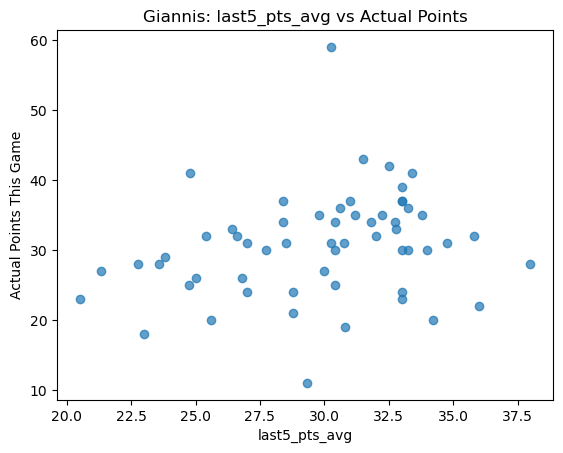

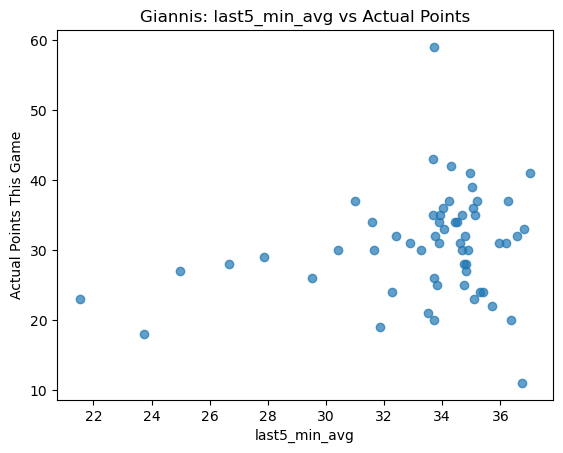

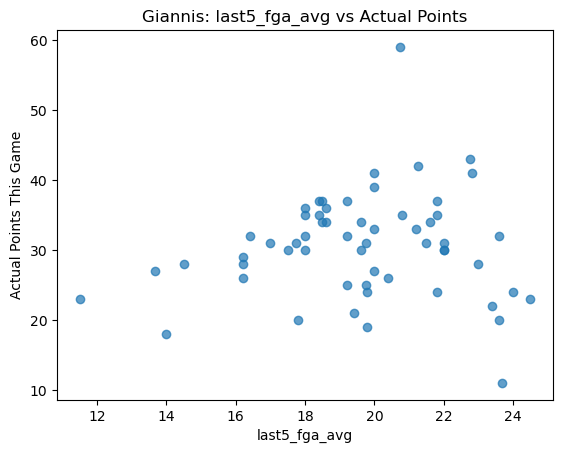

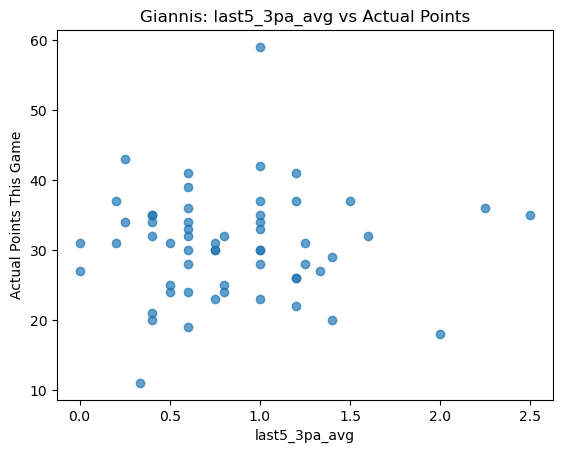

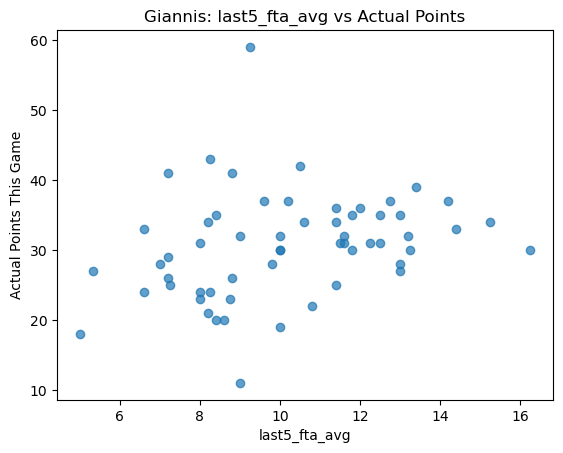

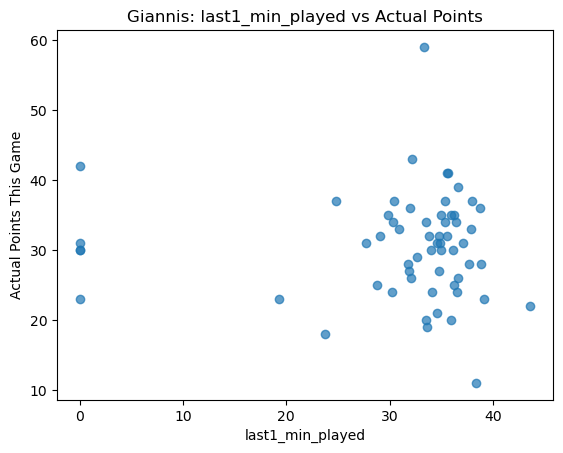

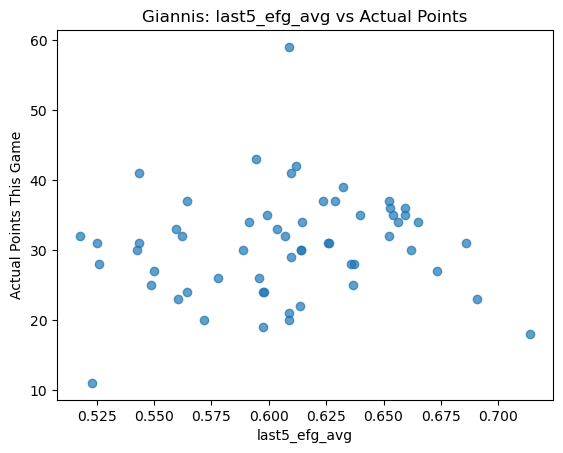

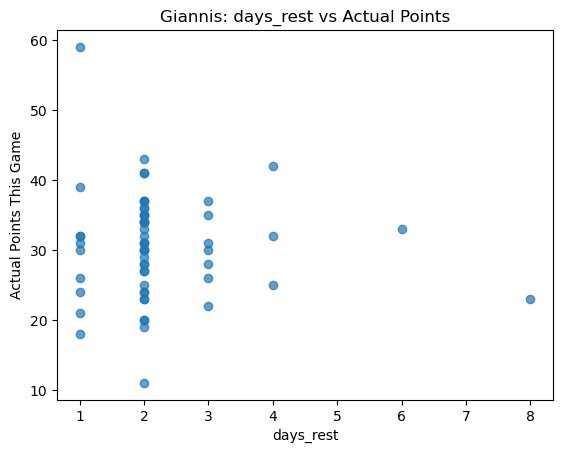

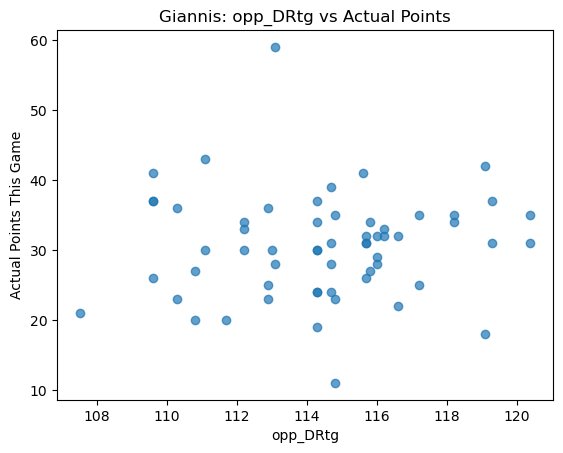

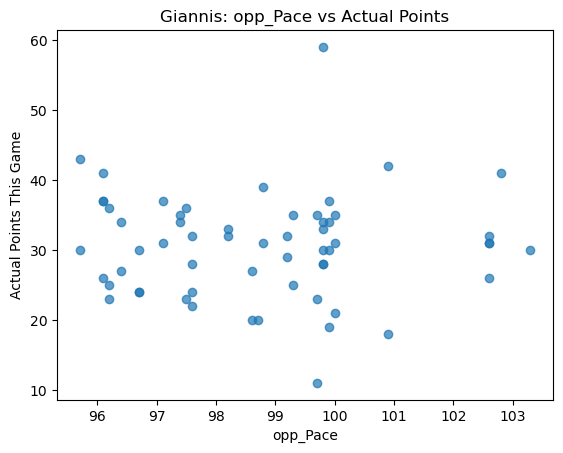

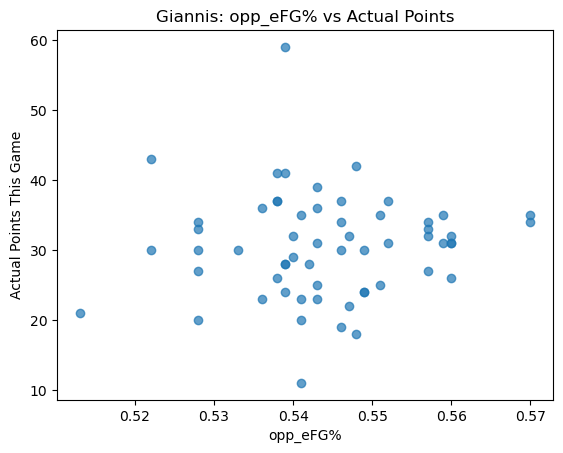

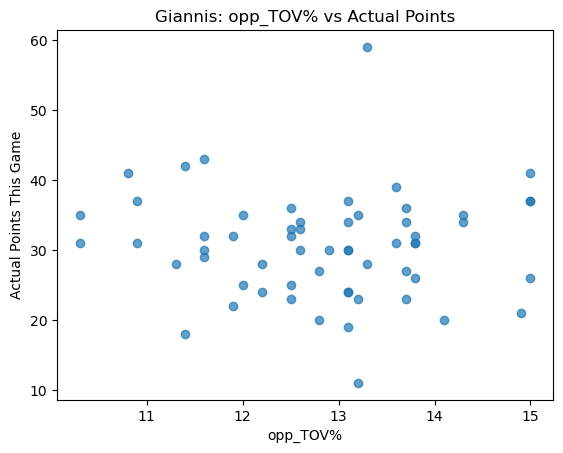

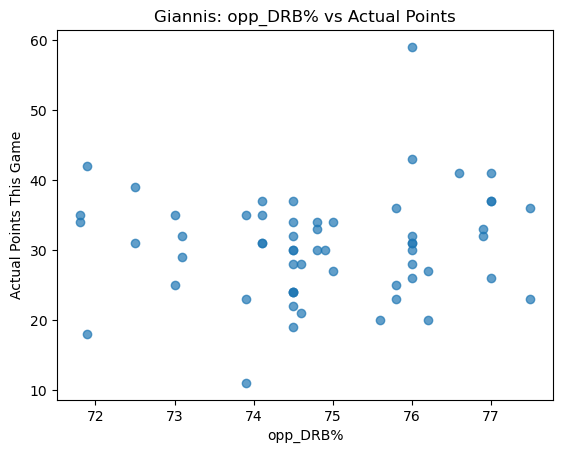

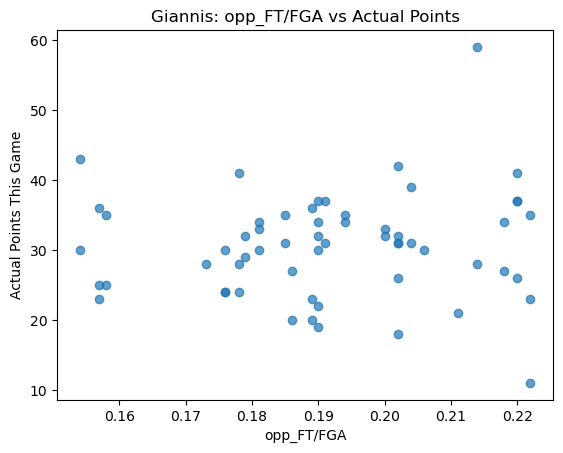

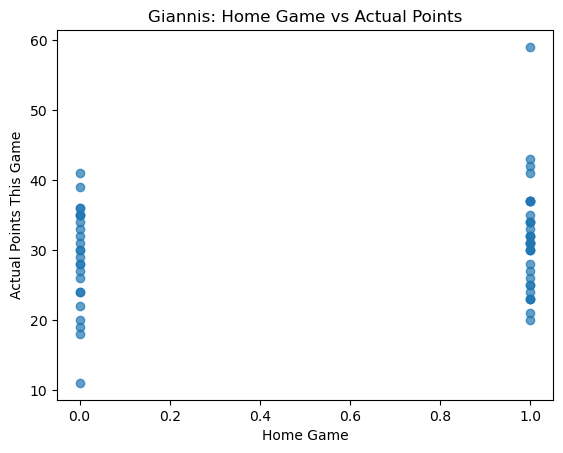

In [223]:
features_to_plot = giannis_feature_set_df.columns

for feature in features_to_plot:
    plt.figure()
    plt.scatter(giannis_feature_set_df[feature], giannis_pts_y_set, alpha=0.7)
    plt.xlabel(feature)
    plt.ylabel("Actual Points This Game")
    plt.title(f"Giannis: {feature} vs Actual Points")
    plt.show()

In [224]:
def compute_cost(x, y_target, w, b):
    y_pred = compute_model_output(x, w, b)
    squared_diff = (y_pred - y) ** 2
    return np.mean(squared_diff) / 2

In [226]:
def compute_gradient(x, y_target, w, b):
    dj_dw = np.dot((compute_model_output(x, w, b) - y_target), x) / len(x)
    dj_db = (compute_model_output(x, w, b) - y_target) / len(x)
    return (dj_dw, dj_db)

In [228]:
def compute_gradient_descent(x, y_target, alpha, iterations):
    w_in = np.zeros(shape=x.shape[1])
    b_in = 0
    cost_history = []
    for i in range(iterations):
        dj_dw, dj_db = compute_gradient(x, y_target, w_in, b_in)
        w = w - alpha * dj_dw
        b = b - alpha * dj_db
        cost_history.append(compute_cost(x, y_target, w, b))
    print(f"dw = {dj_dw} db = {dj_db}")
    # print(f"cost = {compute_cost(x, y_target, w, b)}")
    # Graph the learning curve
    plt.plot(np.arange(iterations), cost_history)
    plt.xlabel('Iterations')
    plt.ylabel('J(w,b)')
    plt.title('Learning Curve')
    plt.show()
    return w, b

In [ ]:
#